<a href="https://colab.research.google.com/github/DhyeyMavani2003/DeepSentiment/blob/main/code/tokenization_naive_bayes_and_bert_models_train_val_test_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing necessary libraries for training, validating, and testing the baseline model

# General libraries for data manipulation and numerical operations
import pandas as pd     # For data manipulation and analysis
import numpy as np      # For numerical operations

# PyTorch libraries for building and training the model
import torch            # Main PyTorch library
import torch.nn as nn   # For building neural network layers
import torch.optim as optim  # For optimization algorithms
from torch.utils.data import Dataset, DataLoader, TensorDataset  # For dataset handling and data loading

# Hugging Face transformers library for pre-trained models
from transformers import BertTokenizer, BertModel  # BERT tokenizer and model
from transformers import AdamW, get_linear_schedule_with_warmup  # Optimizer and learning rate scheduler

# Additional libraries for time tracking, file operations, and regular expressions
import time            # For tracking time during training
import os              # For interacting with the operating system
import re              # For regular expressions

# Scikit-learn libraries for feature extraction and model evaluation
from sklearn.feature_extraction.text import CountVectorizer  # For converting text to a matrix of token counts
from sklearn.feature_extraction.text import TfidfTransformer  # For converting token counts to TF-IDF features
from sklearn.naive_bayes import MultinomialNB  # For the Naive Bayes classifier

# Additional transformers and TensorFlow/Keras libraries for experimenting with different models
from transformers import BertTokenizerFast  # Faster BERT tokenizer
from transformers import TFBertModel  # TensorFlow BERT model
from transformers import RobertaTokenizerFast  # Faster RoBERTa tokenizer
from transformers import TFRobertaModel  # TensorFlow RoBERTa model

# TensorFlow and Keras libraries for deep learning
import tensorflow as tf  # Main TensorFlow library
from tensorflow import keras  # High-level Keras API

# Scikit-learn metrics for evaluating model performance textually and visually
from sklearn.metrics import accuracy_score, f1_score  # For accuracy and F1 score
from sklearn.metrics import classification_report, confusion_matrix  # For detailed classification metrics and confusion matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# Setting random seeds for reproducibility
def set_seed(seed_value):
    np.random.seed(seed_value)  # Set the seed for numpy
    torch.manual_seed(seed_value)  # Set the seed for PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # Set the seed for all CUDA devices

    tf.random.set_seed(seed_value)  # Set the seed for TensorFlow

# Example seed value
seed_value = 42
set_seed(seed_value)

In [3]:
# URLs for the CSV files containing training, validation, and test data
train_url = "https://raw.githubusercontent.com/DhyeyMavani2003/DeepSentiment/main/data/tweeteval/sentiment/csv/pre-token-train-data.csv"
val_url = "https://raw.githubusercontent.com/DhyeyMavani2003/DeepSentiment/main/data/tweeteval/sentiment/csv/pre-token-val-data.csv"
test_url = "https://raw.githubusercontent.com/DhyeyMavani2003/DeepSentiment/main/data/tweeteval/sentiment/csv/pre-token-test-data.csv"

# Reading the CSV files into pandas DataFrames
df_train = pd.read_csv(train_url)
df_val = pd.read_csv(val_url)
df_test = pd.read_csv(test_url)

# Displaying the first few rows of the training DataFrame to verify the data
print(df_train.head())

                                                Text  Label_ID Mapped_Label
0  qt user origin draft th book remu lupin surviv...         2     positive
1  ben smith smith concuss remain lineup thursday...         1      neutral
2  sorri bout stream last night crash tonight sur...         1      neutral
3  chase headley rbi doubl th inning david price ...         1      neutral
4  user alciato bee invest million januari anoth ...         2     positive


TRAINING DATA: 45615
VALIDATION DATA: 2000
TESTING DATA: 12284
	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.81      0.05      0.10      3972
     Neutral       0.52      0.84      0.64      5937
    Positive       0.49      0.51      0.50      2375

    accuracy                           0.52     12284
   macro avg       0.61      0.47      0.42     12284
weighted avg       0.61      0.52      0.44     12284



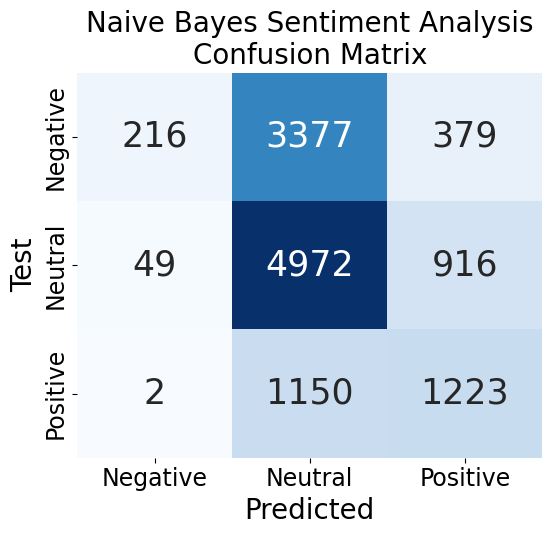

In [4]:
# Trying Naive Bayes as a simpler model than BERT

# Extracting features and labels from the DataFrames
X_train, y_train = df_train['Text'].values, df_train['Label_ID'].values
X_val, y_val = df_val['Text'].values, df_val['Label_ID'].values
X_test, y_test = df_test['Text'].values, df_test['Label_ID'].values

# Copying the labels for later use
y_train_le = y_train.copy()
y_val_le = y_val.copy()
y_test_le = y_test.copy()

# One-hot encoding the labels
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# Printing the number of samples in each dataset
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}\nTESTING DATA: {X_test.shape[0]}")

# Converting text data to numerical data using CountVectorizer
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

# Transforming the numerical data using TF-IDF
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Training a Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)

# Making predictions on the test data
nb_pred = nb_clf.predict(X_test_tf)

# Printing the classification report
print('\tClassification Report for Naive Bayes:\n\n', classification_report(y_test_le, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Function to plot the confusion matrix
def conf_matrix(y, y_pred, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    labels = ['Negative', 'Neutral', 'Positive']
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25}, ax=ax)
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Plotting the confusion matrix
conf_matrix(y_test.argmax(1), nb_pred, 'Naive Bayes Sentiment Analysis\nConfusion Matrix')

In [5]:
# Constants and BERT tokenizer initialization
MAX_LEN = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize data using BERT tokenizer
def tokenize(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,  # Add special tokens [CLS] and [SEP]
            max_length=max_len,  # Pad & truncate all sentences to max_len
            padding='max_length',  # Pad all sentences to max_len
            return_attention_mask=True  # Return attention mask
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

# Tokenizing the training, validation, and test data
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# Loading the pre-trained BERT model from Hugging Face
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to create a sentiment analysis model using BERT
def create_model(bert_model, max_len=MAX_LEN):
    # Model parameters
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Optimizer
    loss = tf.keras.losses.CategoricalCrossentropy()  # Loss function
    accuracy = tf.keras.metrics.CategoricalAccuracy()  # Accuracy metric

    # Model architecture
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')  # Input layer for input IDs
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')  # Input layer for attention masks
    embeddings = bert_model([input_ids, attention_masks])[1]  # BERT embeddings

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)  # Output layer with softmax activation for 3 classes
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)  # Defining the model

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])  # Compiling the model
    return model

# Creating the BERT-based sentiment analysis model
model = create_model(bert_model, MAX_LEN)

# Displaying the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

Epoch 1/2
713/713 [==============================] - 1158s 2s/step - loss: 0.8064 - categorical_accuracy: 0.6224 - val_loss: 0.7479 - val_categorical_accuracy: 0.6555
Epoch 2/2
384/384 [==============================] - 115s 277ms/step
	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.69      0.61      0.65      3972
     Neutral       0.65      0.73      0.69      5937
    Positive       0.64      0.57      0.61      2375

   micro avg       0.66      0.66      0.66     12284
   macro avg       0.66      0.64      0.65     12284
weighted avg       0.66      0.66      0.66     12284
 samples avg       0.66      0.66      0.66     12284



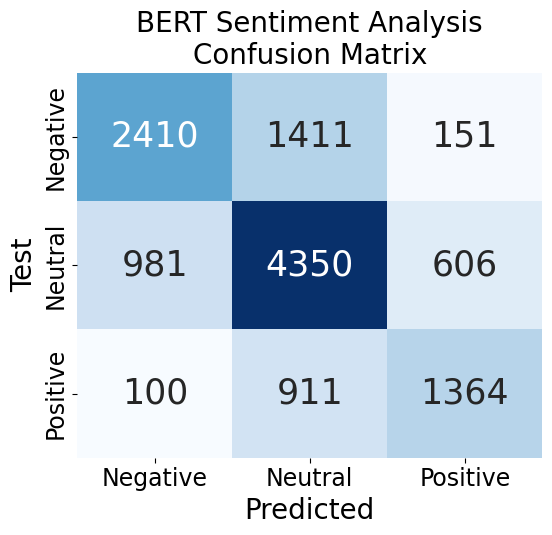

In [6]:
# Training the BERT-based sentiment analysis model
history_bert = model.fit(
    [train_input_ids, train_attention_masks], y_train,  # Training data
    validation_data=([val_input_ids, val_attention_masks], y_val),  # Validation data
    epochs=2,  # Number of epochs
    batch_size=64  # Batch size
)

# Making predictions on the test data
result_bert = model.predict([test_input_ids, test_attention_masks])

# Converting the predictions to one-hot encoded format
y_pred_bert = np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

# Printing the classification report for the BERT model
print('\tClassification Report for BERT:\n\n', classification_report(y_test, y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

# Plotting the confusion matrix for the BERT model
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1), 'BERT Sentiment Analysis\nConfusion Matrix')

In [7]:
# Saving the trained BERT-based sentiment analysis model
model.save("model_bert.keras")

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [8]:
# Initializing the RoBERTa tokenizer
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

# Determining the maximum token length in the training data
token_lens = []
for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length = np.max(token_lens)
print(max_length)

# Function to tokenize data using RoBERTa tokenizer
def tokenize_roberta(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,  # Add special tokens [CLS] and [SEP]
            max_length=max_len,  # Pad & truncate all sentences to max_len
            padding='max_length',  # Pad all sentences to max_len
            return_attention_mask=True  # Return attention mask
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

# Tokenizing the training, validation, and test data
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

# Function to create a sentiment analysis model using RoBERTa
def create_model(bert_model, max_len=MAX_LEN):
    # Model parameters
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Optimizer
    loss = tf.keras.losses.CategoricalCrossentropy()  # Loss function
    accuracy = tf.keras.metrics.CategoricalAccuracy()  # Accuracy metric

    # Model architecture
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')  # Input layer for input IDs
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')  # Input layer for attention masks
    output = bert_model([input_ids, attention_masks])  # RoBERTa model
    output = output[1]  # Get the pooled output
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)  # Output layer with softmax activation for 3 classes
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)  # Defining the model

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])  # Compiling the model
    return model

# Loading the pre-trained RoBERTa model from Hugging Face
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Creating the RoBERTa-based sentiment analysis model
model = create_model(roberta_model, MAX_LEN)

# Displaying the model summary
model.summary()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

49


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

384/384 [==============================] - 109s 257ms/step
	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.59      0.80      0.68      3972
     Neutral       0.71      0.55      0.62      5937
    Positive       0.63      0.60      0.61      2375

   micro avg       0.64      0.64      0.64     12284
   macro avg       0.64      0.65      0.64     12284
weighted avg       0.65      0.64      0.64     12284
 samples avg       0.64      0.64      0.64     12284



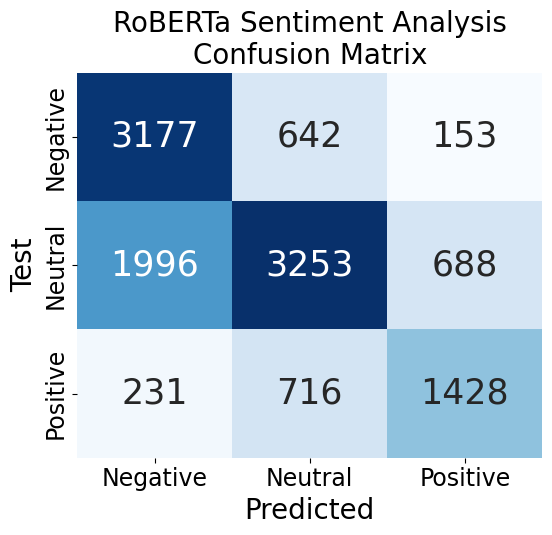

In [9]:
# Training the RoBERTa-based sentiment analysis model
history_2 = model.fit(
    [train_input_ids, train_attention_masks], y_train,  # Training data
    validation_data=([val_input_ids, val_attention_masks], y_val),  # Validation data
    epochs=1,  # Number of epochs
    batch_size=64  # Batch size
)

# Making predictions on the test data
result_roberta = model.predict([test_input_ids, test_attention_masks])

# Converting the predictions to one-hot encoded format
y_pred_roberta = np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

# Printing the classification report for the RoBERTa model
print('\tClassification Report for RoBERTa:\n\n', classification_report(y_test, y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

# Plotting the confusion matrix for the RoBERTa model
conf_matrix(y_test.argmax(1), y_pred_roberta.argmax(1), 'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [10]:
# Saving the trained RoBERTa-based sentiment analysis model
model.save("model_roberta.keras")

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
